# Turn a Kitti image into your own
## Computer Vision and Image Processing - Assignment
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Pierluigi Zama Ramirez, pierluigi.zama@unibo.it - Riccardo Spezialetti, riccardo.spezialetti@unibo.it

## Kitti
[KITTI](http://www.cvlibs.net/datasets/kitti/index.php) is a collection of 42,382 stereo sequences taken in urban environments from two video cameras and a LiDAR device mounted on the roof of a car. This dataset is widely used for benchmarking geometric understanding tasks such as depth, flow and pose estimation. 

<img src="kitti/000000_10.png" width="720">

## Goal
Given a Kitti image alongside the camera instrisics parameters, transform the image as it would have been acquired by your phone camera, i.e. by having your mobile phone mounted in the very exact position and pose as the Kitti camera.

## Data
**Images**: Images in the folder: _"kitti/"_

**Intrinsics Parameters (Camera Matrix A)**: 
$$\begin{bmatrix} 707.0912 & 0.0 & 601.8873 \\ 0.0 & 707.0912 & 183.1104 \\ 0.0 & 0.0 & 1.0 \end{bmatrix}$$

### Step 1: Calibrate your Camera

Calibrate your camera following the procedure of LabSession3.

N.B: Common error in calibration: Acquire images with the same width and height. Changing the alignment of the camera (horizontal and vertical) swaps the height and width of the resulting image (i.e. it is not the same camera anymore).

In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [18]:
dirname = "chessboards/"
img_names = [dirname + str(i) + ".jpg" for i in range(13)]

square_size = 26.5 #mm
pattern_size = (8,5) # number of inner corner

#Building 3D points
indices = np.indices(pattern_size, dtype=np.float32)
indices *= square_size
pattern_points = np.zeros([pattern_size[0]*pattern_size[1], 3], np.float32)
coords_3D = indices.T.reshape(-1, 2)
pattern_points[:, :2] = coords_3D

In [19]:
def processImage(fn):
    print('processing {}'.format(fn))
    img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print("Failed to load", fn)
        return None

    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if found:
        #Refining corner position to subpixel iteratively until criteria  max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        #Image Corners 
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
        
    if not found:
        print('chessboard not found')
        return None

    print('           %s... OK' % fn)
    return (corners.reshape(-1, 2), pattern_points)

In [20]:
# Building 2D-3D correspondeces
chessboards = [processImage(fn) for fn in img_names]
chessboards = [x for x in chessboards if x is not None]

obj_points = [] #3D points
img_points = [] #2D points

for (corners, pattern_points) in chessboards:
        img_points.append(corners)
        obj_points.append(pattern_points)

processing chessboards/0.jpg
           chessboards/0.jpg... OK
processing chessboards/1.jpg
           chessboards/1.jpg... OK
processing chessboards/2.jpg
           chessboards/2.jpg... OK
processing chessboards/3.jpg
           chessboards/3.jpg... OK
processing chessboards/4.jpg
           chessboards/4.jpg... OK
processing chessboards/5.jpg
           chessboards/5.jpg... OK
processing chessboards/6.jpg
           chessboards/6.jpg... OK
processing chessboards/7.jpg
           chessboards/7.jpg... OK
processing chessboards/8.jpg
           chessboards/8.jpg... OK
processing chessboards/9.jpg
           chessboards/9.jpg... OK
processing chessboards/10.jpg
           chessboards/10.jpg... OK
processing chessboards/11.jpg
           chessboards/11.jpg... OK
processing chessboards/12.jpg
           chessboards/12.jpg... OK


In [21]:
# Getting the width and height of the images
h, w = cv2.imread(img_names[0], cv2.IMREAD_GRAYSCALE).shape[:2]

In [22]:
# Calibrating Camera
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

In [23]:
print(camera_matrix)

[[3.07467358e+03 0.00000000e+00 1.51156696e+03]
 [0.00000000e+00 3.08131886e+03 2.00741635e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### Step 2: Warping

Defined as $A_k$ and $A_c$ the 3x3 intrisics matrix of the KITTI camera and our camera. Defined as $R$ and $T$ the relative rotation and translation from the KITTI camera to our camera. Assumed to have no distorsion in our cameras.
Our goal is to find the mapping from a given pixel in homogeneous coordinate of the KITTI camera, $p_k = (u_k, v_k, 1)$, to the corresponding pixel of our camera, $p_c = (u_c, v_c, 1)$. Once estimated the mapping we can warp the KITTI image to appear as it would have taken from our camera.
Generally, assuming that the two frames were acquired at the same time, or that the scene is static, we can find the corresponding pixel in the following way:

$$P_k=z_k*A_k^{-1}p_{k}$$
$$P_c = RP_k + T$$
$$p_c=A_cP_c/z_c$$

where $P_k$ and $P_c$ are the 3D points $(x,y,z)$ expressed in the Kitti and our camera CRF respectively.

However, the two cameras are in the same position. Thus, $R$ is an identity matrix and $T$ is a zeros vector $(0,0,0)$. Thus $P_c = P_k$ and $z_c = z_k$. Therefore, the mapping can be defined as:

$$p_c = A_cA_k^{-1}p_{k}$$

Where $A_cA_k^{-1}$ is a 3x3 matrix representing an homography, $H$, between the two images. 
To obtain the final image we need to warp the KITTI image. We can use the function *cv2.warpPerspective(image, transform, final_size)* of openCV. This function, given an image and a tranformation matrix (e.g. homography), warp the image accordingly. By default it uses the backward warping (to avoid holes), inverting the given homography before applying it. The final_size are the width and height of the destination image (our camera).

*dest_image = warpPerspective($image$, $H$, ($width_c$, $height_c$))*.

N.B: This is only a possible solution. For instance, we could notice that the transformation is just affine, thus we could apply also warpAffine or we could implement our version of backward warping.

We show the solution for only the first image for sake of space.

In [24]:
# Kitti Intrisics Parameters-
k_kitti = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
                    [0.000000e+00, 7.070912e+02, 1.831104e+02], 
                    [0.000000e+00, 0.000000e+00, 1.000000e+00]])

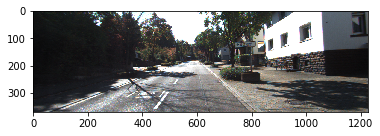

In [25]:
img_kitti = cv2.imread("kitti/000000_10.png")
plt.imshow(img_kitti[:,:,::-1])

In [26]:
# Find the homography between the source and target images
transform = np.matmul(camera_matrix, np.linalg.inv(k_kitti))

In [27]:
# Warp the images accordingly to the found homography
res = cv2.warpPerspective(img_kitti, transform, (w, h))

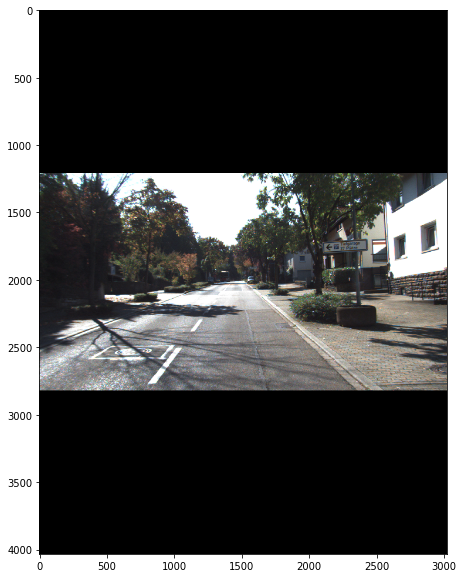

In [28]:
plt.figure(figsize=(20,10))
plt.imshow(res[:,:,::-1])

As we can notice the resulting image is a combination of resize, shift, crop and zero-padding of the original image. 

The resize is coming from the different focal lenghts, the shift from different piercing points and the crop or zero padding from different image sizes and visible areas. The zero padding (i.e. black borders) represents the part of the image that would have been visible from our camera but were not visible from the KITTI camera. On the other hand, the cropped part is the scene visible from the KITTI but not from our camera.
Indeed, if we analyse the function $A_cA_k^{-1}p_k$ we notice that:

$$u^c = \frac{\alpha_x^c}{\alpha_x^k}(u^k - u_0^k) + u_0^c$$
$$v^c = \frac{\alpha_y^c}{\alpha_y^k}(v^k - v_0^k) + v_0^c$$

where $(u^c,v^c)$ is $p_c$ and $(u^k,v^k)$ is $p_k$.
Thus, our transformation first re-center the pixel $(u_k, v_k)$ respect to his piercing point, $(u_0^k,v_0^k)$, then scale the coordinates of a factor $\frac{\alpha_x^c}{\alpha_x^k}$ along the x and $\frac{\alpha_y^c}{\alpha_y^k}$ along y axis.
Then, it shift the resulting pixel using the new piercing point $(u_0^c,v_0^c)$. Finally, the crop or zero padding depends on the resolution of our camera that constrains the max,$(width_c - 1, height_c -1)$, and min, $(0, 0)$ ,values along the x and y axis of the resulting image.

__Final Remarks__

Mapping an image into another without knowing the depth map (i.e. the z values for each pixel) is possible because the resulting transformation was an homography (i.e. mapping between planes) since z was simplified in the calculus.
There are only 3 cases where this can happen.. Try to guess the others!